# **Step 1: Organize The Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
from skimage.transform import resize
import re
import torch.optim as optim
from tqdm import tqdm

In [ ]:
data_path = Path("/content/drive/MyDrive/data_skeleton")

In [ ]:
def save_np_volumes(image_volumes,skeleton_volumes):
  # Define file paths to save the volumes
  image_volumes_path = "/content/drive/MyDrive/image_volumes.npy"
  skeleton_volumes_path = "/content/drive/MyDrive/skeleton_volumes.npy"

  # Save the numpy arrays
  np.save(image_volumes_path, image_volumes)
  np.save(skeleton_volumes_path, skeleton_volumes)

  print(f"Image volumes saved to {image_volumes_path}")
  print(f"Skeleton volumes saved to {skeleton_volumes_path}")

In [ ]:
# Define file paths to load the volumes
image_volumes_path = "/content/drive/MyDrive/Skeleton_Volumes/image_volumes.npy"
skeleton_volumes_path = "/content/drive/MyDrive/Skeleton_Volumes/skeleton_volumes.npy"

# Load the numpy arrays
image_volumes = np.load(image_volumes_path)
skeleton_volumes = np.load(skeleton_volumes_path)

In [ ]:
# Define a function to extract the numeric part of a filename
def extract_number(path):

    match = re.search(r'(\d+)', path.name)

    return int(match.group(1)) if match else float('inf')  # Handle cases with no number

In [ ]:
def load_volume_from_folder(base_path, target_depth = 64, target_shape=(64, 256, 256)):
    """
    Load and resize the first `target_depth` slices of a volume from the given folder.
    The images are stacked along the depth axis (last axis).
    """
    # Sorting and selecting image and skeleton slices
    image_slices = sorted((base_path / "ori").glob("*.png"), key=extract_number)[:target_depth]
    skeleton_slices = sorted((base_path / "skeleton").glob("*.png"), key=extract_number)[:target_depth]

    # Stack image slices along the third axis (depth)
    image_volume = np.dstack([
        resize(
            np.array(Image.open(img).convert("L")),
            target_shape[1:],  # Resize to target height and width
            preserve_range=True,
            anti_aliasing=True,
        ) for img in image_slices
    ])

    # Stack skeleton slices along the third axis (depth)
    skeleton_volume = np.dstack([
        resize(
            np.array(Image.open(skl).convert("L")),
            target_shape[1:],  # Resize to target height and width
            preserve_range=True,
            anti_aliasing=True,
        ) for skl in skeleton_slices
    ])

    return image_volume, skeleton_volume

In [ ]:
image_volumes = []
skeleton_volumes = []

# Iterate over folders and load volumes
for i, folder in enumerate(tqdm(data_path.iterdir(), desc="Processing Folders"), start=1):
    if folder.is_dir():
        images, skeletons = load_volume_from_folder(folder)
        image_volumes.append(images)
        skeleton_volumes.append(skeletons)

Processing Folders: 50it [43:48, 52.58s/it]


In [ ]:
# Convert lists to numpy arrays for convenience and set dtype to float32
image_volumes = np.array(image_volumes, dtype=np.float32)
skeleton_volumes = np.array(skeleton_volumes, dtype=np.float32)

In [ ]:
#save_np_volumes(image_volumes,skeleton_volumes)

In [ ]:
print(f"Image Volumes Shape: {image_volumes.shape}")
print(f"Image Volumes Data Type: {image_volumes.dtype}")

print(f"Skeleton Volumes Shape: {skeleton_volumes.shape}")
print(f"Skeleton Volumes Data Type: {skeleton_volumes.dtype}")

Image Volumes Shape: (50, 256, 256, 64)
Image Volumes Data Type: float32
Skeleton Volumes Shape: (50, 256, 256, 64)
Skeleton Volumes Data Type: float32


## 2D Image of the First Volume

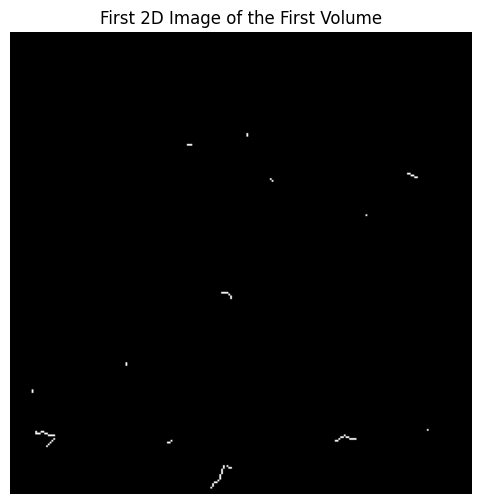

In [ ]:
# Display the first 2D image of the first volume (image_volumes[0, :, :, 0])
plt.figure(figsize=(6, 6))
plt.imshow(skeleton_volumes[0, :, :, 0], cmap='gray')
plt.title("First 2D Image of the First Volume")
plt.axis("off")
plt.show()

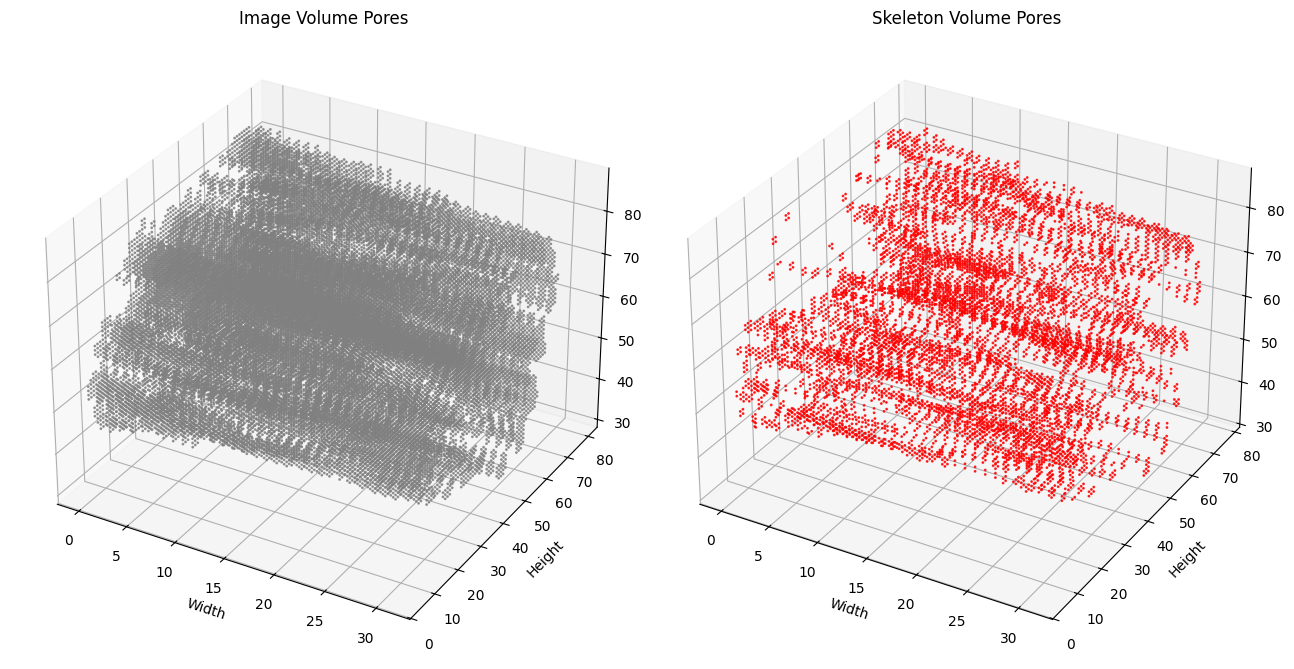

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Replace these with your actual volume data
skeleton_volume = skeleton_volumes[6]  # The first volume in skeleton_volumes
image_volume = image_volumes[6]  # The first volume in image_volumes

# Downsample the volumes to save memory
downsample_factor = 2  # Adjust this factor to balance resolution and memory usage
downsampled_skeleton_volume = skeleton_volume[::downsample_factor, ::downsample_factor, ::downsample_factor]
downsampled_image_volume = image_volume[::downsample_factor, ::downsample_factor, ::downsample_factor]

# Extract the coordinates of the pore space (non-zero values) for both volumes
skeleton_coords = np.array(np.nonzero(downsampled_skeleton_volume))
image_coords = np.array(np.nonzero(downsampled_image_volume))

# Create a figure with two subplots (one for each volume)
fig = plt.figure(figsize=(13, 8))

# Second subplot for image volume
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(image_coords[2], image_coords[1], image_coords[0], s=1, alpha=0.8, color='gray')
ax1.set_xlabel("Width")
ax1.set_ylabel("Height")
ax1.set_zlabel("Depth")
ax1.set_title("Image Volume Pores")

# First subplot for skeleton volume
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(skeleton_coords[2], skeleton_coords[1], skeleton_coords[0], s=1, alpha=0.8, color='red')
ax2.set_xlabel("Width")
ax2.set_ylabel("Height")
ax2.set_zlabel("Depth")
ax2.set_title("Skeleton Volume Pores")

plt.tight_layout()
plt.show()

## Read Data As .raw

3D Volume Shape: (257, 256, 256)
Data Type: uint8


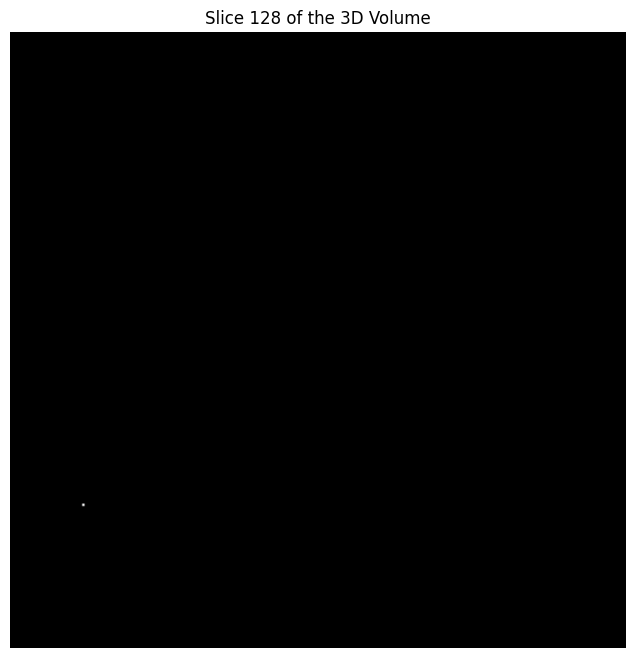

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Path to the .raw file
file_path = "/content/drive/MyDrive/Skeleton_Volumes/skeleton22.raw"

# Specify the 3D volume shape (depth, height, width)
volume_shape = (257, 256, 256)  # Replace with actual dimensions
volume_dtype = np.uint8       # Replace with actual data type

# Read the .raw file
with open(file_path, 'rb') as file:
    volume_data = np.fromfile(file, dtype=volume_dtype)

# Verify the total size matches the expected shape
if volume_data.size != np.prod(volume_shape):
    print(f"Shape mismatch! File contains {volume_data.size} elements, "
          f"but shape requires {np.prod(volume_shape)}")
else:
    # Reshape the data to 3D
    volume_3d = volume_data.reshape(volume_shape)

    # Display information about the 3D volume
    print(f"3D Volume Shape: {volume_3d.shape}")
    print(f"Data Type: {volume_3d.dtype}")

    # Visualize slices
    slice_index = volume_shape[0] // 2  # Middle slice
    plt.figure(figsize=(8, 8))
    plt.imshow(volume_3d[slice_index, :, :], cmap='gray')
    plt.title(f"Slice {slice_index} of the 3D Volume")
    plt.axis('off')
    plt.show()

# **Step 2: Prepare Dataset for PyTorch**

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
class PoreSegmentation3DDataset(Dataset):
    def __init__(self, images, skeletons, transform=None):
        self.images = images
        self.skeletons = skeletons
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        skeleton = self.skeletons[idx]

        # Convert to tensor and normalize
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize the image
        skeleton = torch.tensor(skeleton, dtype=torch.float32) / 255.0  # Normalize the skeleton

        # Ensure binary masks
        skeleton = (skeleton > 0.5).float()

        # Add channel dimension (C, D, H, W) -> (1, 64, 256, 256)
        image = image.unsqueeze(0)  # Add channel dimension: (1, 64, 256, 256)
        skeleton = skeleton.unsqueeze(0)  # Add channel dimension: (1, 64, 256, 256)

        return image, skeleton

# **Step 3: Split Data**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data into train, validation, and test sets
train_images, test_images, train_skeletons, test_skeletons = train_test_split(image_volumes, skeleton_volumes, test_size=0.2)

train_images, val_images, train_skeletons, val_skeletons = train_test_split(train_images, train_skeletons, test_size=0.2)

# Create Dataset objects
train_dataset = PoreSegmentation3DDataset(train_images, train_skeletons)
val_dataset = PoreSegmentation3DDataset(val_images, val_skeletons)
test_dataset = PoreSegmentation3DDataset(test_images, test_skeletons)

# Create DataLoader objects
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Test the data loader
for volumes, skeletons in train_loader:
    print("Input Shape",volumes.shape)  # Expected shape: torch.Size([1, 1, 64, 256, 256])
    print("Skeleton Shape", skeletons.shape)
    break

Input Shape torch.Size([1, 1, 256, 256, 64])
Skeleton Shape torch.Size([1, 1, 256, 256, 64])


# **Step 4: Build the 3D U-Net**

In [ ]:
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool3d(2)

        self.upconv1 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv3 = self.upconv_block(128, 64)

        self.final = nn.Conv3d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Decoding with skip connections
        dec1 = self.upconv1(enc4)
        dec1 = dec1 + enc3  # Skip connection
        dec2 = self.upconv2(dec1)
        dec2 = dec2 + enc2  # Skip connection
        dec3 = self.upconv3(dec2)
        dec3 = dec3 + enc1  # Skip connection

        final = self.final(dec3)
        return final

# **Step 5: Train the Model**

In [ ]:
def dice_loss(pred, target, smooth=1e-6, foreground_weight=0.95, background_weight=0.05):
    # Apply sigmoid activation to the predictions
    pred = torch.sigmoid(pred)

    # Interpolate target to match pred shape
    target = torch.nn.functional.interpolate(target, size=pred.shape[2:], mode="trilinear", align_corners=True)

    # Flatten for Dice loss computation
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    # Calculate the intersection, sum of predictions, and sum of targets
    intersection = (pred * target).sum(dim=1)
    pred_sum = pred.sum(dim=1)
    target_sum = target.sum(dim=1)

    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)

    # Apply weights: foreground gets a higher weight, background gets a lower weight
    weighted_dice = foreground_weight * dice * target.mean() + background_weight * dice * (1 - target.mean())

    return 1 - weighted_dice.mean()

def iou_score(pred, target, smooth=1e-6):
    """
    IoU Score for 3D volumetric skeleton data.
    """
    pred = torch.sigmoid(pred)  # Apply sigmoid
    pred = (pred > 0.5).float()  # Thresholding
    intersection = (pred * target).sum(dim=(1, 2, 3, 4))  # Adjust for 3D (B, D, H, W)
    union = pred.sum(dim=(1, 2, 3, 4)) + target.sum(dim=(1, 2, 3, 4)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjust UNet for 3D input and output channels
model = UNet3D(1, 1).to(device)  # Replace `UNet` with a 3D version like `UNet3D`
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
history = {
    "train_loss": [],
    "val_loss": [],
    "iou_score": []
}

In [ ]:
import os
import torch

# Create a directory to save checkpoints
checkpoint_dir = "/content/drive/MyDrive/checkpoints_skeleton_extratction"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Function to save a checkpoint
def save_checkpoint(epoch, model, optimizer, history, filepath):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "history": history,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch + 1}")

# Function to load a checkpoint
def load_checkpoint(filepath, model, optimizer):
    history = {
        "train_loss": [],
        "val_loss": [],
        "iou_score": []
    }

    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        history = checkpoint["history"]
        start_epoch = checkpoint["epoch"] + 1
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}")
        return start_epoch, history
    else:
        print("No checkpoint found. Starting training from scratch.")
        return 0, history

In [ ]:
# Path to the checkpoint file
checkpoint_path = os.path.join(checkpoint_dir, "model_checkpoint.pth")

# Load the checkpoint if available
start_epoch, history = load_checkpoint(checkpoint_path, model, optimizer)

In [ ]:
epochs = 100

# Training loop
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0
    for volumes, skeletons in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        volumes, skeletons = volumes.to(device), skeletons.to(device)

        optimizer.zero_grad()

        outputs = model(volumes)

        # print(f"Pred shape: {outputs.shape}, Target shape: {skeletons.shape}")

        loss = dice_loss(outputs, skeletons)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch + 1}: Train Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0.0
    iou = 0.0
    with torch.no_grad():
        for volumes, skeletons in val_loader:
            volumes, skeletons = volumes.to(device), skeletons.to(device)
            outputs = model(volumes)

            val_loss += dice_loss(outputs, skeletons).item()
            iou += iou_score(outputs, skeletons).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    history["iou_score"].append(avg_iou)
    print(f"Validation Loss: {avg_val_loss}, IoU Score: {avg_iou}")

    # Save checkpoint
    save_checkpoint(epoch, model, optimizer, history, checkpoint_path)

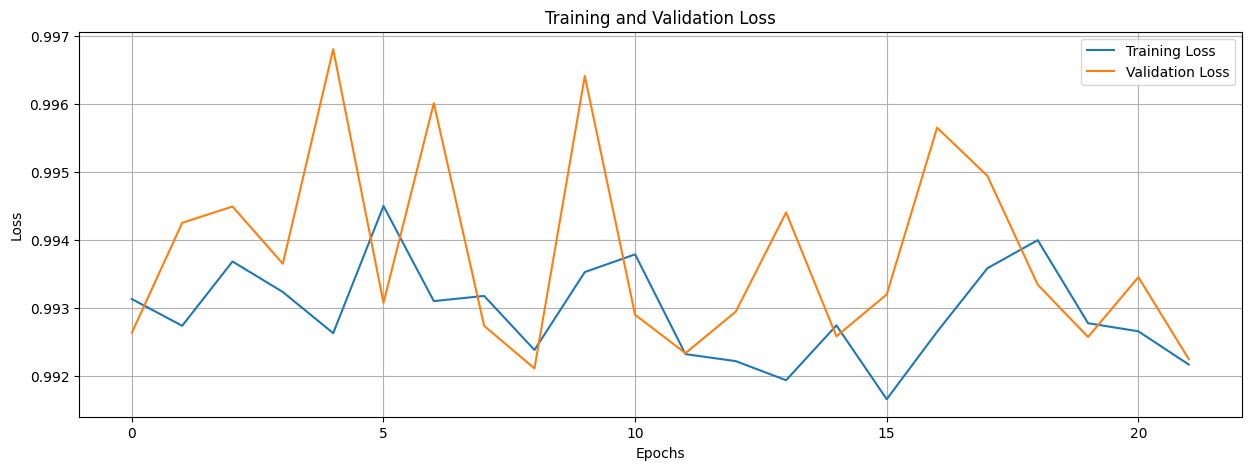

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

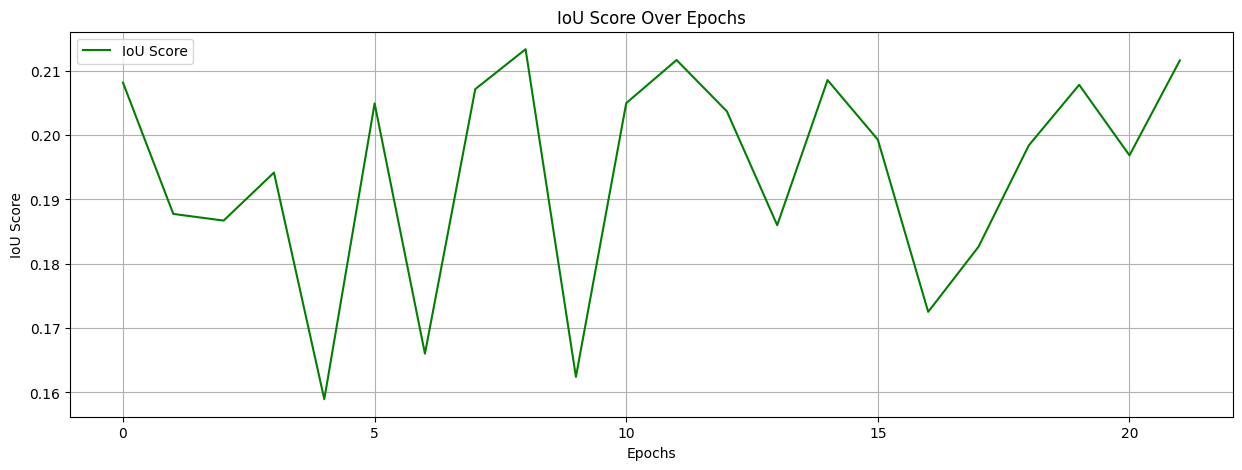

In [ ]:
# Plot IoU score
plt.figure(figsize=(15, 5))
plt.plot(history["iou_score"], label="IoU Score", color="green")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.grid()
plt.show()

# **Step 6: Evaluate the Model**

# **Step 7: Interpret Results**

# **3D CNN**

In [ ]:
import torch.nn.functional as F

In [ ]:
class Light3DCNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Light3DCNN, self).__init__()

        self.conv1 = nn.Conv3d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool3d(2)  # Keep downsampling to reduce memory

        self.fc1 = nn.Linear(4194304, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
def focal_loss(pred, target, gamma=2.0, alpha=0.25, smooth=1e-6):
    pred = torch.sigmoid(pred)  # Apply sigmoid to get probabilities
    target = target.float()  # Ensure target is a float tensor

    # Compute the cross-entropy loss
    bce_loss = - target * torch.log(pred + smooth) - (1 - target) * torch.log(1 - pred + smooth)

    # Compute the focal loss term
    loss = alpha * (1 - pred) ** gamma * bce_loss

    return loss.mean()

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjust UNet for 3D input and output channels
model_cnn = Light3DCNN(1, 1).to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

In [ ]:
# Training loop with Focal Loss

epochs = 10

for epoch in range(0, epochs):
    model_cnn.train()
    running_loss = 0.0
    for volumes, skeletons in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        volumes, skeletons = volumes.to(device), skeletons.to(device)

        optimizer.zero_grad()

        outputs = model_cnn(volumes)

        # Focal loss instead of Dice loss
        loss = focal_loss(outputs, skeletons)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch + 1}: Train Loss: {avg_train_loss}")

    model_cnn.eval()
    val_loss = 0.0
    iou = 0.0
    with torch.no_grad():
        for volumes, skeletons in val_loader:
            volumes, skeletons = volumes.to(device), skeletons.to(device)
            outputs = model_cnn(volumes)

            val_loss += focal_loss(outputs, skeletons).item()
            iou += iou_score(outputs, skeletons).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    history["iou_score"].append(avg_iou)
    print(f"Validation Loss: {avg_val_loss}, IoU Score: {avg_iou}")

Epoch 1/10:   0%|          | 0/32 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 47.06 MiB is free. Process 632436 has 14.70 GiB memory in use. Of the allocated memory 14.08 GiB is allocated by PyTorch, and 495.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)